In [3]:
import os
import torch
import numpy as np
import collections
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.optim as optim

In [11]:
DATA_ROOT = '/kaggle/input'
BATCH_SIZE = 32
IMG_SIZE = 224

# Explicitly map folder keywords to IDs
# We check these strings inside the file path.
FOLDER_TO_LABEL = {
    'Benign': 0,
    'Early': 1,   # Matches "Early Pre-B"
    'Pre': 2,     # Matches "Pre-B" (careful not to match "Early Pre" double)
    'Pro': 3      # Matches "Pro-B"
}

# Display names
CLASS_NAMES = {
    0: 'Benign', 
    1: 'Early Pre-B', 
    2: 'Pre-B', 
    3: 'Pro-B'
}

In [39]:
# 0 = CML, 1 = CLL, 2 = Acute (Merged)
FOLDER_TO_LABEL = {
    'Benign': 0,
    'Early Pre-B': 1,
    'Pre-B': 2,# Acute
    'Pro-B': 3  # Healthy
}

CLASS_NAMES = {0: 'CLL', 1: 'ALL(Pro)', 2: 'ALL(Pre)', 3:'Healthy'}

In [12]:
# ==========================================
# 2. ROBUST CRAWLER
# ==========================================
def find_images_strict(root_dir):
    paths = []
    labels = []
    print(f"🕵️ Scanning {root_dir}...")
    
    for root, dirs, files in os.walk(root_dir):
        # We check the folder path against our keywords
        root_lower = root.lower() # specific normalization
        
        detected_id = None
        
        # Priority Check (Longer names first to avoid confusion)
        if 'early' in root_lower:
            detected_id = 1
        elif 'pre' in root_lower:
            detected_id = 2
        elif 'pro' in root_lower:
            detected_id = 3
        elif 'benign' in root_lower:
            detected_id = 0
            
        # If we found a valid class
        if detected_id is not None:
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    paths.append(os.path.join(root, file))
                    labels.append(detected_id)
                    
    return paths, labels

all_paths, all_labels = find_images_strict(DATA_ROOT)

print(f"\n✅ Total Images: {len(all_paths)}")
for i in range(4):
    print(f"   Class {i} ({CLASS_NAMES[i]}): {all_labels.count(i)}")

if len(all_paths) == 0: raise ValueError("No images found!")

🕵️ Scanning /kaggle/input...

✅ Total Images: 3242
   Class 0 (Benign): 512
   Class 1 (Early Pre-B): 979
   Class 2 (Pre-B): 955
   Class 3 (Pro-B): 796


In [13]:
print(f"Total Images Found: {len(all_paths)}")

Total Images Found: 3242


In [14]:
# ==========================================
# 3. BALANCED SPLIT (Per-Class)
# ==========================================
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

print("\n--- Splitting Each Class Separately ---")

for cls_idx in range(4):
    # Get files for this class
    cls_paths = [p for p, l in zip(all_paths, all_labels) if l == cls_idx]
    
    # Optional: Undersample if huge imbalance (>1500 images)
    if len(cls_paths) > 2000:
        random.shuffle(cls_paths)
        cls_paths = cls_paths[:2000]
        
    cls_groups = [os.path.dirname(p) for p in cls_paths]
    unique_patients = list(set(cls_groups))
    
    print(f"Class {cls_idx}: {len(cls_paths)} images | {len(unique_patients)} Patients")
    
    # LOGIC: If many patients, use GroupSplit. If few, use RandomSplit.
    if len(unique_patients) >= 4:
        # Train (70%)
        splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=42)
        train_idx, temp_idx = next(splitter.split(cls_paths, groups=cls_groups))
        
        X_train.extend([cls_paths[i] for i in train_idx])
        y_train.extend([cls_idx] * len(train_idx))
        
        # Temp paths/groups for Val/Test
        temp_paths = [cls_paths[i] for i in temp_idx]
        temp_groups = [cls_groups[i] for i in temp_idx]
        
        # Val (15%) / Test (15%)
        splitter_val = GroupShuffleSplit(test_size=0.50, n_splits=1, random_state=42)
        val_idx, test_idx = next(splitter_val.split(temp_paths, groups=temp_groups))
        
        X_val.extend([temp_paths[i] for i in val_idx])
        y_val.extend([cls_idx] * len(val_idx))
        
        X_test.extend([temp_paths[i] for i in test_idx])
        y_test.extend([cls_idx] * len(test_idx))
    else:
        # Fallback for rare classes
        c_train, c_temp = train_test_split(cls_paths, test_size=0.30, random_state=42)
        c_val, c_test = train_test_split(c_temp, test_size=0.50, random_state=42)
        
        X_train.extend(c_train); y_train.extend([cls_idx]*len(c_train))
        X_val.extend(c_val); y_val.extend([cls_idx]*len(c_val))
        X_test.extend(c_test); y_test.extend([cls_idx]*len(c_test))

print("-" * 30)
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Verify Validation Set isn't broken
val_counts = collections.Counter(y_val)
print(f"Val Distribution: {dict(val_counts)}")
if len(val_counts) < 4:
    print("❌ CRITICAL: Validation set is missing a class! Check the 'Class X' prints above.")
else:
    print("✅ Validation set has all 4 classes.")


--- Splitting Each Class Separately ---
Class 0: 512 images | 1 Patients
Class 1: 979 images | 1 Patients
Class 2: 955 images | 1 Patients
Class 3: 796 images | 1 Patients
------------------------------
Train: 2268 | Val: 486 | Test: 488
Val Distribution: {0: 77, 1: 147, 2: 143, 3: 119}
✅ Validation set has all 4 classes.


In [15]:
# --- 4. RAM-CACHED DATASET CLASS ---
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size, mode="train"):
        self.paths = file_paths
        self.data = []  # Stores actual images in RAM
        self.labels = labels
        self.mode = mode
        
        # 1. DEFINE TRANSFORMS (Must happen for ALL modes)
        # ------------------------------------------------
        if mode == "train":
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # This 'else' block ensures Validation/Test sets get a transform too
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # 2. LOAD IMAGES INTO RAM
        # ------------------------------------------------
        print(f"📥 Loading {mode} data into RAM ({len(file_paths)} images)...")
        resize_tool = transforms.Resize((img_size, img_size))
        
        for path in tqdm(file_paths):
            try:
                with Image.open(path) as img:
                    img = img.convert('RGB')
                    img_resized = resize_tool(img)
                    self.data.append(img_resized)
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                # Fallback: Black image to prevent crash
                self.data.append(Image.new('RGB', (img_size, img_size)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch image from RAM
        img = self.data[idx]
        label = self.labels[idx]
        
        # Apply the transform defined in __init__
        img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.long)

# --- RE-INITIALIZE LOADERS ---
# You must re-run this part to apply the new Class definition
print("\nRe-creating DataLoaders...")

# Ensure these variables (X_train, y_train, etc.) exist from your previous split steps
train_ds = CachedDataset(X_train, y_train, IMG_SIZE, mode="train")
val_ds = CachedDataset(X_val, y_val, IMG_SIZE, mode="val")
test_ds = CachedDataset(X_test, y_test, IMG_SIZE, mode="test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ DataLoaders Fixed. You can run training now.")


Re-creating DataLoaders...
📥 Loading train data into RAM (2268 images)...


100%|██████████| 2268/2268 [00:37<00:00, 61.29it/s]


📥 Loading val data into RAM (486 images)...


100%|██████████| 486/486 [00:08<00:00, 56.44it/s]


📥 Loading test data into RAM (488 images)...


100%|██████████| 488/488 [00:08<00:00, 57.10it/s]


✅ DataLoaders Fixed. You can run training now.


In [24]:
import torch
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
client_1_path = '/kaggle/input/all-healthy/pytorch/default/1/swin_transformer_fl_weights.pth'
client_2_path = '/kaggle/working/swin_transformer_all.pth'
output_global_path = 'Global_Federated_Model.pth'

In [31]:
# ==========================================
# 2. FEDERATED AVERAGING (The "Server" Logic)
# ==========================================
def federated_average(weight_paths, output_path):
    """
    Loads weights from multiple clients, averages them, and saves the Global Model.
    """
    print(f"\n🔄 STARTING AGGREGATION from: {weight_paths}")
    
    # 1. Load the first client's weights as a "base"
    if not os.path.exists(weight_paths[0]):
        raise FileNotFoundError(f"❌ Cannot find file: {weight_paths[0]}")
        
    global_weights = torch.load(weight_paths[0], map_location='cpu')
    
    # 2. Add up weights from all other clients
    for i in range(1, len(weight_paths)):
        if not os.path.exists(weight_paths[i]):
            raise FileNotFoundError(f"❌ Cannot find file: {weight_paths[i]}")
            
        client_weights = torch.load(weight_paths[i], map_location='cpu')
        
        for key in global_weights:
            global_weights[key] += client_weights[key]
            
    # 3. Divide by number of clients to get the Average
    n_clients = len(weight_paths)
    for key in global_weights:
        global_weights[key] = global_weights[key] / n_clients
        
    # 4. Save the new Global Model
    torch.save(global_weights, output_path)
    print(f"✅ Aggregation Complete. Global Model saved to: {output_path}")
    return output_path

In [32]:
# ==========================================
# 3. RELIABILITY TESTING (Using YOUR test_loader)
# ==========================================
def test_reliability(model_path, loader):
    print(f"\n⚖️ TESTING RELIABILITY on {len(loader.dataset)} Test Images...")
    
    # 1. Re-build the model architecture
    # (Using the build_model function from your previous code)
    model = build_model() 
    
    # 2. Load the Aggregated Global Weights
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # 3. Evaluation Loop
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating Global Model"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.numpy())
            
    # 4. Generate Report
    # Ensure CLASS_NAMES matches your labels: 0=CML, 1=CLL, 2=Acute, 3=Healthy
    class_names_list = ["CML", "CLL", "Acute (Pro)", "Healthy"]
    
    print("\n" + "="*50)
    print("       FEDERATED GLOBAL MODEL RESULTS       ")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names_list))
    
    # 5. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title("Reliability Check: Global Model vs Test Data")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()

🚀 Found client weights. Proceeding with Federated Learning...

🔄 STARTING AGGREGATION from: ['/kaggle/input/all-healthy/pytorch/default/1/swin_transformer_fl_weights.pth', '/kaggle/working/swin_transformer_all.pth']
✅ Aggregation Complete. Global Model saved to: Global_Federated_Model.pth

⚖️ TESTING RELIABILITY on 488 Test Images...
Building Custom Swin Transformer (4 Classes: Benign, Early, Pre, Pro)...


Evaluating Global Model: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]



       FEDERATED GLOBAL MODEL RESULTS       
              precision    recall  f1-score   support

         CML       0.41      0.56      0.48        77
         CLL       0.71      0.65      0.68       147
 Acute (Pro)       0.86      0.82      0.84       144
     Healthy       1.00      0.94      0.97       120

    accuracy                           0.76       488
   macro avg       0.75      0.74      0.74       488
weighted avg       0.78      0.76      0.76       488



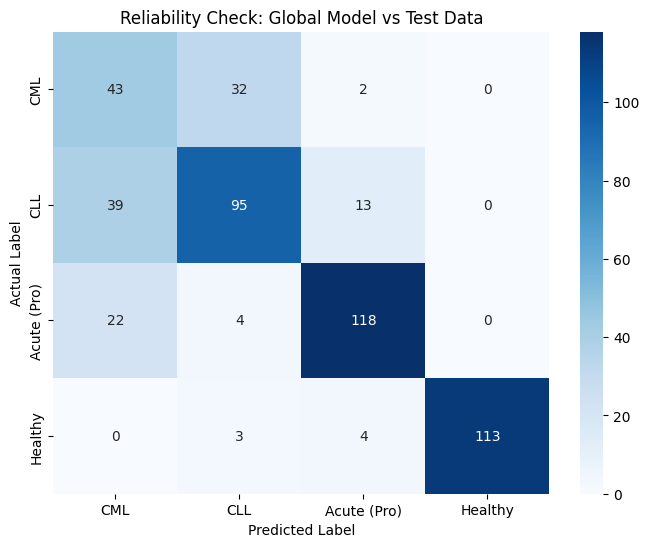

In [33]:
if os.path.exists(client_1_path):
    print(f"🚀 Found client weights. Proceeding with Federated Learning...")
    
    # Step A: Aggregate Client Models into One Global Model
    # We pass the list of client paths and the desired output filename
    global_model_path = federated_average([client_1_path, client_2_path], output_global_path)
    
    # Step B: Validate the Global Model
    # We test it on the held-out test_loader to ensure it generalizes
    test_reliability(global_model_path, test_loader)
    
else:
    print(f"❌ Error: Could not find client weight file: {client_1_path}")
    print("   Please ensure you have run the training loop for the clients first.")